In [1]:
from tqdm.notebook import trange, tqdm
# from tqdm import tqdm

import plotly.graph_objects as go
from time import sleep

from data_gen.preprocess import pre_normalization
from infer.visualize_ntu_skel import draw_skeleton_offline, _plot_skel

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")


TRN_LABL_PATH = '../data/data/ntu/xview/train_label.pkl'
VAL_LABL_PATH = '../data/data/ntu/xview/val_label.pkl'

TRN_DATA_PATH = '../data/data/ntu/xview/train_data_joint.npy'
VAL_DATA_PATH = '../data/data/ntu/xview/val_data_joint.npy'


def load_data(data_path, label_path):
    # data: N C T V M
    # with open(label_path) as f:
    #     sample_name, label = pickle.load(f)
    with open(label_path, 'rb') as f:
        sample_name, label = pickle.load(f, encoding='latin1')
    data = np.load(data_path, mmap_mode='r')
    return data, sample_name, label


def get_data(index, data=None, label=None):
    label = None if label is None else label[index]
    data_numpy = None if data is None else np.array(data[index])
    return data_numpy, label


def stack_data_index(data, pid=0):
    index_dict = {}
    c = 0
    for n in trange(len(data)):
        data_n, _ = get_data(n, data=data)
        for m in range(data_n.shape[-1]):
            data_n_m = data_n[:, :, :, m]  # C T V
            data_n_m = np.swapaxes(data_n_m, 0, 2)  # V T C
            if ~np.all(data_n_m == 0.0):
                for t in range(data_n_m.shape[1]):
                    data_n_m_t = data_n_m[:, t:t+1, :]  # V 1 C
                    if ~np.all(data_n_m_t == 0.0):
                        if index_dict.get(n, None) is None:
                            index_dict[n] = {m: {t: data_n_m_t}}
                        elif index_dict[n].get(m, None) is None:
                            index_dict[n][m] = {t: data_n_m_t}
                        elif index_dict[n][m].get(t, None) is None:
                            index_dict[n][m][t] = data_n_m_t  # V 1 C
                        c += 1
    return index_dict, c


def stack_data_along_temporal_axis(data, index_dict, counter, pid=0):
    stacked_data = np.zeros((25, counter, 3))
    c = 0
    for n in tqdm(index_dict.keys()):
        for m in index_dict[n].keys():
            for t in index_dict[n][m].keys():
                data_n_m_t = data[n, :, t:t+1, :, m]  # C 1 V
                data_n_m_t = np.swapaxes(data_n_m_t, 0, 2)  # V 1 C
                stacked_data[:, c:c+1, :] = data_n_m_t  # V 1 C
                c += 1
    print("Finished stacking data.")
    return stacked_data


def stack_label_along_temporal_axis(label, index_dict, counter, pid=0):
    stacked_label = np.zeros((counter))
    c = 0
    for n in tqdm(index_dict.keys()):
        for m in index_dict[n].keys():
            for t in index_dict[n][m].keys():
                stacked_label[c:c+1] = label[n]
                c += 1
    print("Finished stacking label.")
    return stacked_label


def stack_samplename_along_temporal_axis(sample_name, index_dict, counter, pid=0):
    stacked_name = np.array(['' for _ in range(counter)], dtype=object)
    c = 0
    for n in tqdm(index_dict.keys()):
        for m in index_dict[n].keys():
            for t in index_dict[n][m].keys():
                stacked_name[c:c+1] = sample_name[n]
                c += 1
    print("Finished stacking samplename.")
    return stacked_name


In [78]:
val_data, val_sample_name, val_label = load_data(VAL_DATA_PATH, VAL_LABL_PATH)
print(f'Number of val data samples : {len(val_sample_name)}')

Number of val data samples : 18932


In [15]:
if os.path.exists('../data/data/ntu/xview/non_zero_val_joint.npy'):
    val_stacked_data = np.load('../data/data/ntu/xview/non_zero_val_joint.npy', mmap_mode='r')
    val_stacked_label = np.load('../data/data/ntu/xview/non_zero_val_label.npy', mmap_mode='r')
    val_stacked_samplename = np.load('../data/data/ntu/xview/non_zero_val_sname.npy', allow_pickle=True)
    print("Loaded non-zero data")
else:
    val_index_dict, val_counter = stack_data_index(val_data)
    val_stacked_data = stack_data_along_temporal_axis(val_data, val_index_dict, val_counter)
    val_stacked_label = stack_label_along_temporal_axis(val_label, val_index_dict, val_counter)
    val_stacked_samplename = stack_samplename_along_temporal_axis(val_sample_name, val_index_dict, val_counter)
    np.save('../data/data/ntu/xview/non_zero_val_joint.npy', val_stacked_data)
    np.save('../data/data/ntu/xview/non_zero_val_label.npy', val_stacked_label)
    np.save('../data/data/ntu/xview/non_zero_val_sname.npy', val_stacked_samplename)
    print("Loaded and saved non-zero data")

Loaded non-zero data


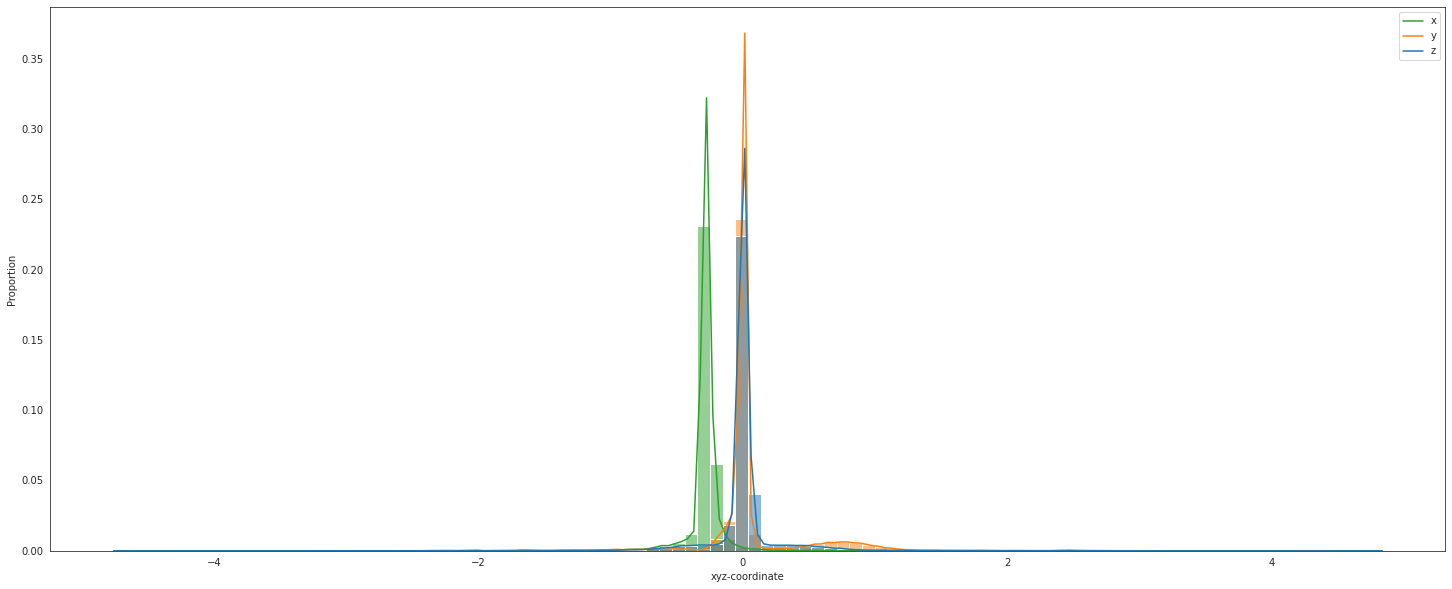

In [24]:
plt.figure(figsize=(25, 10))
sns.histplot(data=val_stacked_data[0, :, :], kde=True, stat='proportion', bins=100)
plt.xlabel('xyz-coordinate')
# plt.xlim(-2, 2)
plt.legend(['x', 'y', 'z'])
plt.show()


In [69]:
val_stacked_label.max()

59.0

In [71]:
# count, data_range = np.histogram(val_stacked_data[0, :, 2], bins=100)  # z (height)
extreme_z_idxs = np.where(val_stacked_data[0, :, 2] >= 2)
print(np.unique(val_stacked_samplename[extreme_z_idxs]))

['S001C001P006R002A059.skeleton' 'S008C001P030R001A018.skeleton'
 'S011C001P008R002A060.skeleton' 'S015C001P008R002A059.skeleton']


In [73]:
dummy_data = np.swapaxes(val_stacked_data, 0, 1)[
    val_stacked_samplename == 'S008C001P030R001A018.skeleton'][:,:,2]
# np.where(dummy_data >= 2)
dummy_data.shape

(576, 25)

In [43]:
# S008C001P030R001A018, S015C001P008R002A059
data = np.swapaxes(val_stacked_data, 0, 1)[
    val_stacked_samplename == 'S008C001P030R001A018.skeleton'][300:, :, :]
data = np.expand_dims(np.swapaxes(np.swapaxes(data, 0, 2), 1, 2), axis=-1)
# draw_skeleton_offline(data)

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=0, y=3.0, z=0)
)
fig = go.Figure(
    data=_plot_skel(data, 0),
    # layout=go.Layout(
    #     updatemenus=[dict(type="buttons",
    #                       buttons=[dict(label="Play",
    #                                     method="animate",
    #                                     args=[None])])]),
    # frames=[go.Frame(data=_plot_skel(data, k))
    #         for k in range(data.shape[1])]
)
fig.update_layout(scene_camera=camera,
                  showlegend=False,
                  margin=dict(l=0, r=0, b=0, t=0),
                  yaxis=dict(range=[-1, 1]),
                  xaxis=dict(range=[-1, 1]))
fig.show(renderer='notebook_connected')


In [76]:
file_name = r'/workspaces/2s-AGCN/data/data/nturgbd_raw/nturgb+d_skeletons/S008C001P030R001A018.skeleton'  # noqa
max_V = 25  # Number of nodes
max_M = 2  # Number of skeletons
with open(file_name, 'r') as fr:
    frame_num = int(fr.readline())
    data = np.zeros((3, frame_num, 25, 2))
    for frame in range(frame_num):
        person_num = int(fr.readline())
        for person in range(person_num):
            fr.readline()
            joint_num = int(fr.readline())
            for joint in range(joint_num):
                v = fr.readline().split(' ')
                if joint < max_V and person < max_M:
                    data[0, frame, joint, person] = float(
                        v[0])  # A coordinate of a joint
                    data[1, frame, joint, person] = float(v[1])
                    data[2, frame, joint, person] = float(v[2])
x = np.expand_dims(data, axis=0)
data_norm = pre_normalization(x)
data_norm.shape

0
[ 0.1111967 -0.0451813  0.       ] 0.8006102754423305


(1, 3, 84, 25, 2)

In [95]:
np.sum(val_data[val_sample_name.index("S008C001P030R001A018.skeleton")][:,0,:,0], axis=0)

array([-0.19579424,  0.        ,  0.19972633,  0.20693246,  0.1688112 ,
        0.10367496,  0.21166793,  0.24078707,  0.26182532,  0.19704475,
        0.03948405,  0.00707334, -0.17874837, -0.43496123, -0.70354176,
       -0.67022926, -0.20126307, -0.04126982, -0.42340755, -0.53629845,
        0.15013228,  0.28969333,  0.20323566, -0.05468196,  0.00637142],
      dtype=float32)

In [ ]:
trn_data, trn_sample_name, trn_label = load_data(TRN_DATA_PATH, TRN_LABL_PATH)
print(f'Number of trn data samples : {len(trn_sample_name)}')

In [ ]:
trn_index_dict, trn_counter = stack_data_index(trn_data)
trn_stacked_data = stack_data_along_temporal_axis(trn_data, trn_index_dict, trn_counter)
trn_stacked_label = stack_label_along_temporal_axis(trn_label, trn_index_dict, trn_counter)
trn_stacked_samplename = stack_samplename_along_temporal_axis(trn_sample_name, trn_index_dict, trn_counter)

In [ ]:
# outputs = parallel_processing(stack_data_along_temporal_axis, 4, trn_data, trn_label)
# data_list = [i[0] for i in outputs]
# label_list = [i[1] for i in outputs]
# stacked_data = np.concatenate(data_list, axis=0)
# stacked_label = np.concatenate(label_list, axis=0)
stacked_data = stack_data_along_temporal_axis(trn_data)
stacked_label = stack_label_along_temporal_axis(trn_data, trn_label)
plt.figure(figsize=(25, 10))
sns.histplot(data=stacked_data[0, :, :], kde=True, stat='proportion')
plt.xlabel('xyz-coordinate')
plt.xlim(-2, 2)
plt.legend(['x', 'y', 'z'])
plt.show()


In [ ]:
# del stacked_data, stacked_label, trn_data, trn_label

In [ ]:
plt.figure(figsize=(25, 10))
sns.histplot(data=stacked_data[0, :, :], kde=True, stat='proportion')
plt.xlabel('xyz-coordinate')
# plt.xlim(-2, 2)
plt.legend(['x', 'y', 'z'])
plt.show()

In [ ]:
plt.figure(figsize=(25, 10))
sns.histplot(data=stacked_data[0, :, :], kde=True, stat='proportion', bins=1000)
plt.xlabel('xyz-coordinate')
plt.xlim(-1, 1)
plt.legend(['x', 'y', 'z'])
plt.show()

In [ ]:
unique_data_point, index = np.unique(stacked_data[0, :, 0], return_index=True)
np.histogram(unique_data_point, bins=10)

In [ ]:
unique_data_point, index = np.unique(stacked_data[0, :, 1], return_index=True)
np.histogram(unique_data_point, bins=10)

In [ ]:
unique_data_point, index = np.unique(stacked_data[0, :, 2], return_index=True)
np.histogram(unique_data_point, bins=10)

In [ ]:
print(stacked_data[0, :, :][stacked_data[0, :, 2] == unique_data_point[unique_data_point > 3]])
print(stacked_label[stacked_data[0, :, 2] == unique_data_point[unique_data_point > 3]])

In [ ]:
stacked_label.max()